In [ ]:
# !pip install --upgrade tensorflow

In [ ]:
# Step 1: Pytorch and Training Metadata
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path
from torch import no_grad
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications import ImageDataGenerator

#hyperparameters
batch_size = 128
epochs = 10
lr = 0.001
try_cuda = True
seed = 1000

# Architecture
num_classes = 10

#otherum
logging_interval = 10 # how many batches to wait before logging
logging_dir = None
grayscale = True

In [ ]:
# 1) setting up the logging

datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    runs_dir = Path("./") / Path(f"runs/")
    runs_dir.mkdir(exist_ok = True)

    logging_dir = runs_dir / Path(f"{datetime_str}")

    logging_dir.mkdir(exist_ok = True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)  # tensorboard

#deciding whether to send to the cpu or not if available
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.manual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)

print(cuda)

True


In [ ]:
import pandas as pd
import os
from glob import glob

from google.colab import drive
drive.mount('/content/mydrive')

# Check if the directory exists before trying to access it.
dir_path = '/content/mydrive/MyDrive/ELEC576_final/Data'

if os.path.exists(dir_path):
    os.listdir(dir_path)  # List the directory's contents
else:
    print(f"Directory not found: {dir_path}")  # Print an informative message

# show all the files and folders in 'Data'
print(os.listdir('/content/mydrive/MyDrive/ELEC576_final/Data'))

all_xray_df = pd.read_csv('/content/mydrive/MyDrive/ELEC576_final/Data/Data_Entry_2017_v2020.csv')
print(f"Data_Entry_2017_v2020.csv is read into a df of {all_xray_df.shape}")
print(f"The columns are:\n{all_xray_df.columns}")

unique_paths = all_xray_df['Finding Labels'].unique()
#print(unique_paths)
all_xray_df.sample(3)

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).
['images_001', 'Data_Entry_2017_v2020.csv', 'images_003', 'Data_Entry_2017_v2020.gsheet']
Data_Entry_2017_v2020.csv is read into a df of (112120, 11)
The columns are:
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]'],
      dtype='object')
Scans found: 0 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
2081,00000541_003.png,No Finding,1,541,48,F,PA,2992,2991,0.143,0.143,None
90852,00022622_003.png,Infiltration,9,22622,60,M,PA,2992,2991,0.143,0.143,None
71094,00017528_008.png,Cardiomegaly|Effusion,8,17528,60,M,AP,2500,2048,0.168,0.168,None


***   There are 112120 images in the database.
The first 15 most frequent labels:
Finding Labels
No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Atelectasis|Effusion         1165
Pleural_Thickening           1126
Cardiomegaly                 1093
Emphysema                     892
Infiltration|Nodule           829
Name: count, dtype: int64

***  The total Number of unique labels in this database: 836
***  Total percentage of the first 15 labels: 84.27%

Percentages of the first 15 most frequent types:
Finding Labels
No Finding                  53.84%
Infiltration                 8.51%
Atelectasis                  3.76%
Effusion                     3.53%
Nodule                       2.41%
Pneumothorax

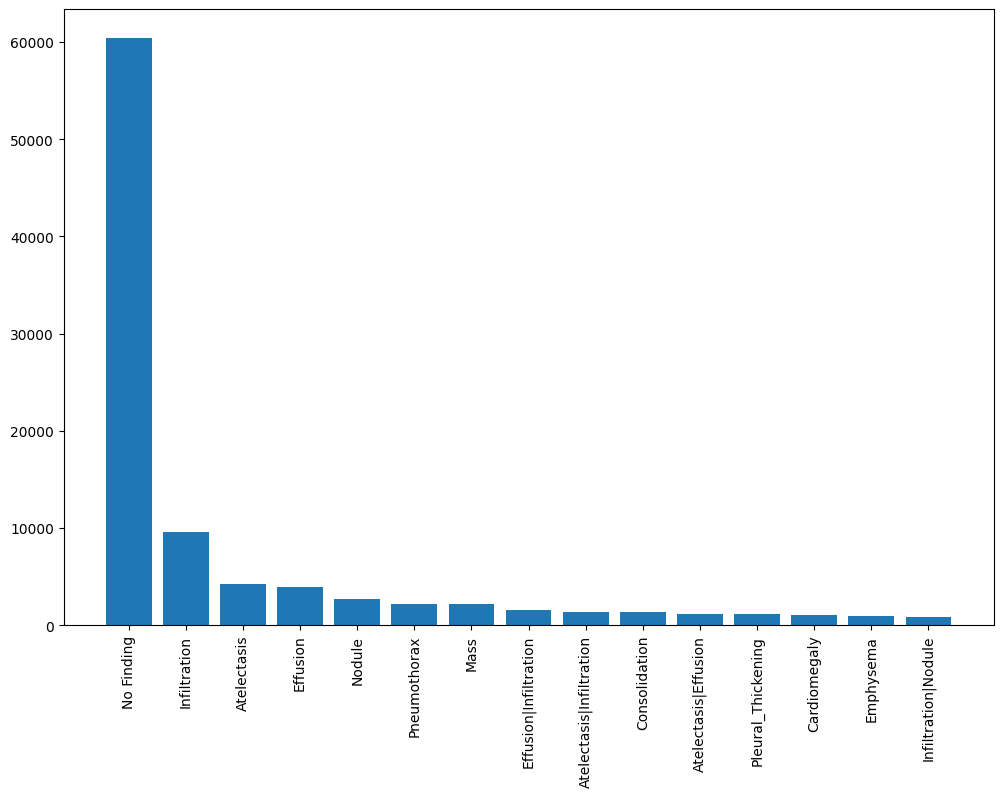

In [ ]:
import matplotlib.pyplot as plt # Importing the matplotlib.pyplot module
import numpy as np # Importing the numpy module

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

# Calculate the total number of observations
total_observations = len(all_xray_df)
print(f"***   There are {total_observations} images in the database.")
print(f"The first 15 most frequent labels:\n{label_counts}")

# Get the number of unique labels
num_unique_labels = all_xray_df['Finding Labels'].nunique()
# Print the result
print(f"\n***  The total Number of unique labels in this database: {num_unique_labels}")

# Calculate the percentages
label_percentages = (label_counts / total_observations) * 100
# Calculate the total percentage of the top 15 labels
total_percentage = label_percentages.sum()
# Print the total percentage with 2 decimal places and % sign
print(f"***  Total percentage of the first 15 labels: {total_percentage:.2f}%")

# Format the percentages with 2 decimal places and % sign
formatted_percentages = label_percentages.apply(lambda x: f'{x:.2f}%')
# Print the formatted percentages
print("\nPercentages of the first 15 most frequent types:")
print(formatted_percentages)

fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
from itertools import chain

all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
85102,00020977_000.png,,0,20977,48,M,PA,2718,2991,0.143,0.143,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30899,00008046_018.png,,5,8046,31,F,AP,2500,2048,0.171,0.171,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50628,00012834_033.png,Effusion|Nodule,33,12834,33,M,AP,2048,2500,0.168,0.168,None,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print("Total data entries in the dataset before cleanup (get rid of cases < 1000 cases) :", f"{len(all_xray_df):,}")
total_cases = sum([all_xray_df[c_label].sum() for c_label in all_labels])
percentage = total_cases/len(all_xray_df)*100
print("Total data entries in the dataset after cleanup (get rid of cases < 1000 cases) :  ", f"{int(total_cases):,}")
print(f"Percentage of data entries after cleanup: {percentage:.2f}%")
print('Clean Labels ({})'.format(len(all_labels)),
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Total data entries in the dataset before cleanup (get rid of cases < 1000 cases) : 112,120
Total data entries in the dataset after cleanup (get rid of cases < 1000 cases) :   80,949
Percentage of data entries after cleanup: 72.20%
Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


The dataset df is now reduced to:  1,000 (1000, 26)
The 26 columns are:
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
59008,00014607_008.png,Atelectasis|Infiltration,8,14607,59,M,PA,2982,2991,0.143,0.143,None,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
97689,00025787_012.png,Effusion|Infiltration|Nodule,12,25787,27,M,AP,3056,2544,0.139,0.139,None,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
101471,00026963_029.png,Infiltration,29,26963,42,F,AP,3056,2544,0.139,0.139,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


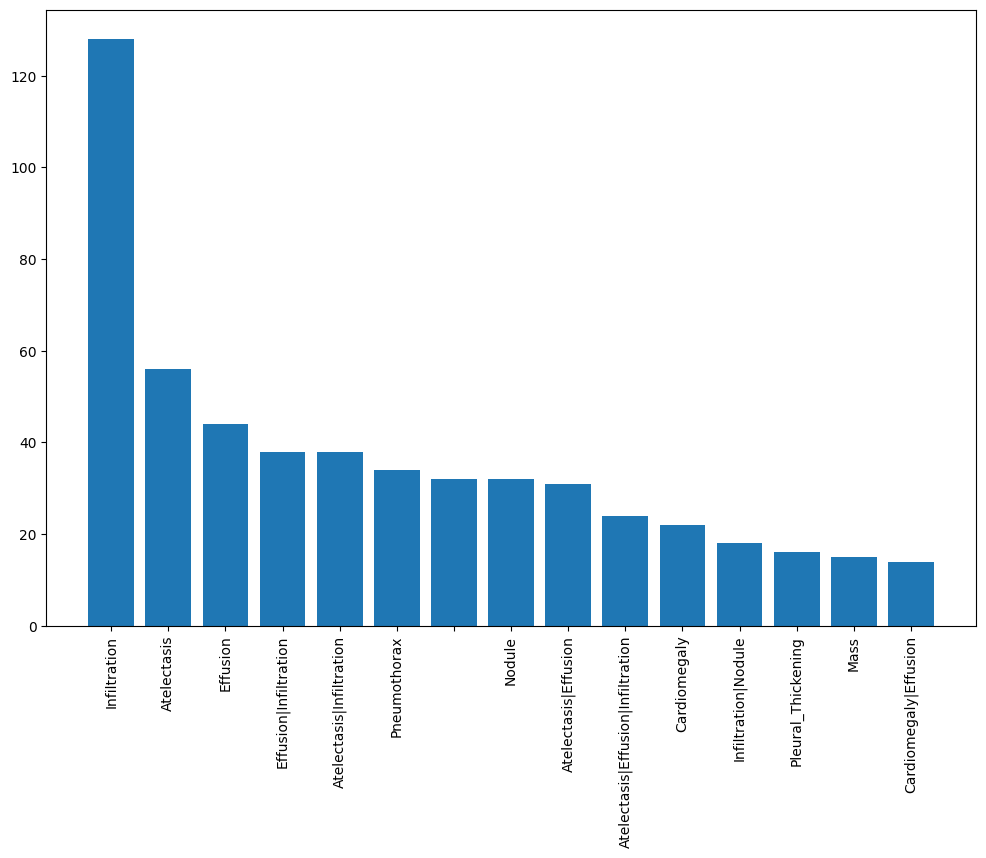

In [ ]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
#all_xray_df = all_xray_df.sample(40000, weights=sample_weights)
all_xray_df = all_xray_df.sample(1000, weights=sample_weights)

print("The dataset df is now reduced to: ", f"{len(all_xray_df):,}", all_xray_df.shape)
print(f"The {len(all_xray_df.columns)} columns are:\n{all_xray_df.columns}")

# the 'path' column specifies where the image png file locates.

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

all_xray_df.sample(3)

In [ ]:
#add the column to the image predicts,  a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [ ]:
# Set display options to show all columns and rows without truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full column width

print(all_xray_df['disease_vec'].sample(3))
print(all_xray_df.shape)

28980    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
8737     [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
90498    [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Name: disease_vec, dtype: object
(1000, 27)


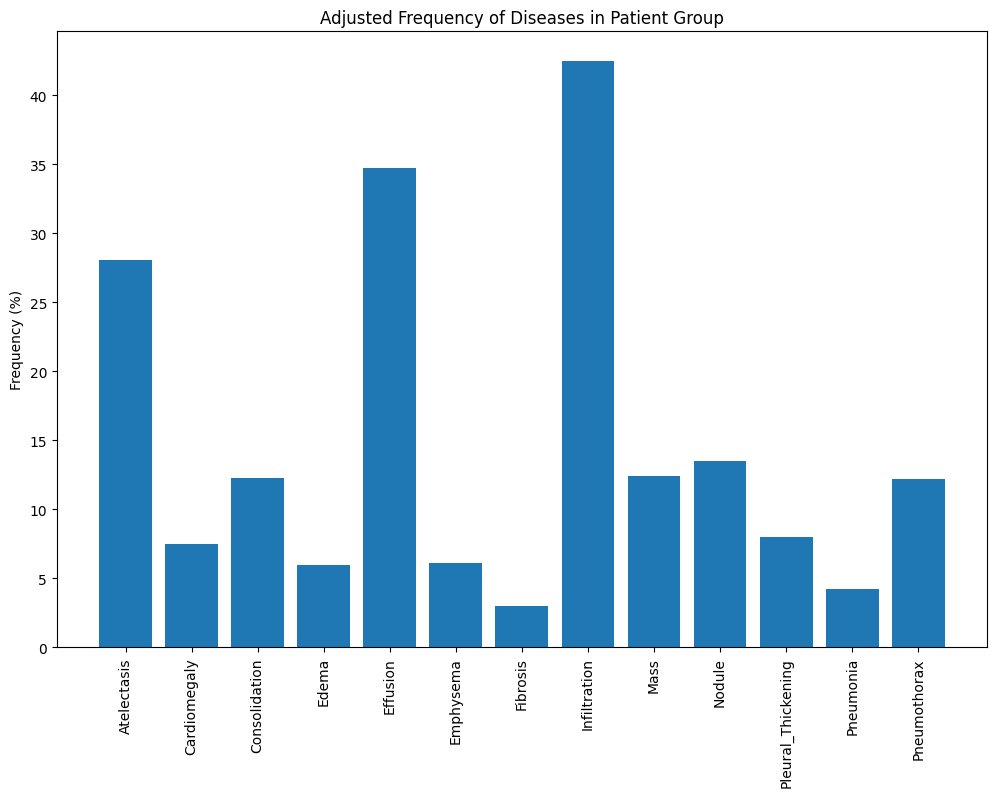

In [ ]:
#this code calculates the frequencies of diseases from patient data,
#then visualizes those frequencies as a bar chart with appropriate labels and titles.

label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)

ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [ ]:
# complete the path information for each image.
#print(all_xray_df.columns)
print(all_xray_df['path'].sample(2))  # Print 2 sample paths

all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('/content/mydrive/MyDrive/ELEC576/Data', 'images*', '*.png'))}
#                   glob(os.path.join('/content/mydrive/MyDrive/ELEC576/Data', 'images*', '*', '*.png'))}

# import itertools  # for islice if needed

# # Print the first 10 items (adjust as needed)
# for key, value in itertools.islice(all_image_paths.items(), 10):
#     print(f"Key: {key}, Value: {value}")

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].astype(int)
#print(all_xray_df.sample(3))
print(all_xray_df.shape)

# Check for null paths (which indicate missing files) and drop them
all_xray_df = all_xray_df.dropna(subset=['path'])

print("After dropping null paths:")
print(all_xray_df.shape)

# Check for empty strings in the 'path' column
empty_paths = all_xray_df[all_xray_df['path'] == '']

# Print the number of empty paths
print(f"Number of empty paths: {len(empty_paths)}")

# Optionally, print the rows with empty paths
if all_xray_df['path'].isnull().any() == True:
  print("problem!!!")
else:
  print("no problem")

27118    None
30668    None
Name: path, dtype: object
Scans found: 112178 , Total Headers 1000
(1000, 27)
After dropping null paths:
(1000, 27)
Number of empty paths: 0
no problem


In [ ]:
# # - download the data
# # - create the pytorch datasets
# #     scaling
# # - create pytorch dataloaders
# #     transforms
# #     batch size

# #normalize = transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5,0.5,0.5])
# normalize = transforms.Normalize(mean = [0.5], std = [0.5])
# transform = transforms.Compose(
#     [transforms.RandomHorizontalFlip(),
#      #transforms.RandomCrop(size = 28, padding = [0,2,3,4]),
#      transforms.RandomCrop(size = 28),
#      transforms.Grayscale(num_output_channels=1),
#      transforms.ToTensor(),
#      normalize])

# #train_dataset = datasets.CIFAR10(root = './CIFAR', train = True, transform = transform, download = True)
# #test_dataset = datasets.CIFAR10(root = './CIFAR', train = False, transform = transform, download = True)
# #train_dataset = datasets.CIFAR10(root = './content/mydrive/ELEC576_final/data/images_001', train = True, transform = transform, download = True)
# test_dataset = datasets.CIFAR10(root = './/content/mydrive/ELEC576_final/data/images_001', train = False, transform = transform, download = True)
# print(train_dataset)
# print(test_dataset)

from sklearn.model_selection import train_test_split

# "stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4])" is the crucial
# part for stratification. It ensures that the proportion of samples in each
# class (represented by the first 4 characters of the 'Finding Labels' column)
# is maintained in both the training and validation sets. This is important
# for imbalanced datasets to prevent one set from having a disproportionate
# number of samples from a particular class.

# Reducing dataset size increases the probability of the least populated class in
# y (output) has only 1 member, which is too few.  The minimum number of groups
# for any class cannot be less than 2 arises when using train_test_split with
# stratification.  This means that at least one of the classes (defined by the
# 'Finding Labels' column). has only one sample in your dataset after applying any
# filters or sampling. When you stratify the split, you are requesting that the
# train and test sets maintain the same proportion of samples from each class as
# the original dataset. However, if a class has only one sample, it is impossible
# to split it into two or more sets while preserving the proportions, leading to the error.

# Calculate the frequency of each unique label in the 'Finding Labels' column
label_frequencies = all_xray_df['Finding Labels'].value_counts()

# Filter out labels with only one occurrence
valid_labels = label_frequencies[label_frequencies > 1].index

# Create a boolean mask indicating rows with valid labels
valid_mask = all_xray_df['Finding Labels'].isin(valid_labels)

# Apply the mask to select only rows with valid labels
filtered_df = all_xray_df[valid_mask]

train_df, valid_df = train_test_split(all_xray_df,
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

#print(all_xray_df.sample(3))
#print(train_df.sample(3))
#print(valid_df.sample(3))
print(train_df.shape)
print(valid_df.shape)
print(train_df.columns)
#print(train_df[0])

train 750 validation 250
(750, 27)
(250, 27)
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'disease_vec'],
      dtype='object')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, batch_size, **dflow_args):
    """
    Creates a generator that yields batches of image data and labels from a DataFrame.

    Args:
        img_data_gen: An ImageDataGenerator instance for data augmentation.
        in_df: The DataFrame containing image paths and labels.
        path_col: The name of the DataFrame column containing image paths.
        y_col: The name of the DataFrame column containing labels.
        **dflow_args: Additional arguments for the generator (e.g., target_size, batch_size).

    Returns:
        A generator that yields batches of image data and labels.
    """

    # Get the total number of samples
    total_samples = in_df.shape[0]

    # Create an empty list to store the images and labels
    all_data_x = []
    all_data_y = []

    # Loop through each image path in the DataFrame
    for index, row in in_df.iterrows():
        img_path = row[path_col]  # Get the image path
        img = load_img(img_path, **dflow_args)  # Load the image
        img_array = img_to_array(img)  # Convert to NumPy array
        img_array = img_data_gen.random_transform(img_array)  # Apply random transformations
        img_array = img_data_gen.standardize(img_array)  # Standardize the image

        all_data_x.append(img_array)  # Append the image to the list
        all_data_y.append(row[y_col])  # Append the label to the list

    # # Convert lists to numpy array
    # all_data_x = np.array(all_data_x)
    # all_data_y = np.array(all_data_y)

    # fit() later on complains the invalid data type.  So ...
    # Convert lists to numpy array
    all_data_x = np.array(all_data_x, dtype=np.float32)  # Explicitly set dtype to float32
    all_data_y = np.array(all_data_y, dtype=np.float32)  # Explicitly set dtype to float32

    # Create a generator from the image data and labels
    # Define a function to generate batches of data
    def data_generator(X, y, batch_size):
        num_samples = X.shape[0]
        indices = np.arange(num_samples)
        while True:
            np.random.shuffle(indices)  # Shuffle the data
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:min(i + batch_size, num_samples)]
                yield X[batch_indices], y[batch_indices]

    # Create the generator
    generator = data_generator(all_data_x, all_data_y, batch_size)

    return generator

In [ ]:
IMG_SIZE = (128, 128)
# This ImageDataGenerator is configured to perform a variety of data augmentation techniques
# on the images, including centering, normalization, flipping, shifting, rotation,
# shearing, and zooming. These transformations help create a more diverse training dataset,
# which can lead to better generalization performance of your deep learning model.

# If any of the parameters related to augmentation (e.g., horizontal_flip,
# rotation_range, zoom_range) are set to values other
# than their defaults (usually 0 or False), then augmentation is being applied.

# core_idg = ImageDataGenerator(samplewise_center=True,
#                               samplewise_std_normalization=True,
#                               horizontal_flip = True,
#                               vertical_flip = False,
#                               height_shift_range= 0.05,
#                               width_shift_range=0.1,
#                               rotation_range=5,
#                               shear_range = 0.1,
#                               fill_mode = 'reflect',
#                               zoom_range=0.15)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = False, #= True,
                              vertical_flip = False,
                              height_shift_range = 0.0, #= 0.05,
                              width_shift_range = 0.0, # =0.1,
                              rotation_range = 0, # =5,
                              shear_range = 0, # = 0.1,
                              fill_mode = 'nearest', # 'reflect',
                              zoom_range = 0) #=0.15)

In [ ]:
# create the training data generator for the training images.
train_gen = flow_from_dataframe(core_idg,
                                train_df,
                                path_col = 'path',
                                y_col = 'disease_vec',
                                batch_size = 32,
                                target_size = IMG_SIZE,
                                color_mode = 'grayscale'
                                )
# i = 0
# for filename in train_gen.filenames:
#       i = i + 1
#       # if len(filename) < len("/content/mydrive/MyDrive/ELEC576/Data/images_012/00028974_024.png"):
#       #   print("Problem", filename)
#       #   break
#       if i %1000 == 0:
#         print(f"{i}:")
#         try:
#             print(f"filename: {filename}")
#  #           image = Image.open(filename)
#  #           print("Image opened successfully")
#             # ... process the image ...
#         except Exception as e:
#             print("Error Loading Image:", filename, e)

# Print the batch shape to confirm the batch size
#t_x, t_y = next(train_gen)
#print("Batch Shape:", t_x.shape, t_y.shape)

# Check a sample image path
# sample_path = train_df['path'].iloc[0]  # Adjust the index as needed
# print("Sample Path:", sample_path)
# print("Path Exists:", os.path.exists(sample_path))

# print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
# #print(train_gen.filenames)
# print(f"train_gen.filenames len: len(train_gen.filenames)")
# print(f"train_gen.filepaths: {train_gen.filepaths}")
# print(f"train_gen.filepaths length", len(train_gen.filepaths))
# print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

# create training datasets X and y
# start_index = train_gen.batch_index * train_gen.batch_size
# start_index = train_gen.filepaths

# from tensorflow.keras.utils import load_img  # Import load_img
# print(f"train_gen shape: {train_gen.index_array.shape}")

# for i, j in enumerate(train_gen.index_array):
#   print("******************************************************")
#   print(f"i, j: {i}, {j}")
#   print(f"train_gen.index_array[i]: {train_gen.index_array[i]}")
#   if j == train_gen.index_array[i]:
#     print("j is the output of enumeration of train_gen.index_array")
#   else:
#     print("j is not the output of enumeration of train_gen.index_array")

#   target_index = j  # The number to find
#   positions = np.where(train_gen.index_array == target_index)[0]
#   if positions.size > 0:
#       print(f"The index {target_index} is found at position(s): {positions}")
#   else:
#       print(f"The index {target_index} is not found in index_array.")

#   if i == 10:
#     break

# print(f"train_gen.filepaths: {train_gen.filepaths}")

# iter = 0
# for j in range(30000):
#   print(f"train_gen.index_array[j]: {train_gen.filepaths_new[j]}")
#   iter += 1
#   if iter == 10:
#     break

  #img = load_img(train_gen.filepaths[j])

# end_index = min(start_index + train_gen.batch_size, train_gen.n)

# print("Starting index:", start_index)
# print("Ending index:", end_index)
# print("Batch size:", train_gen.batch_size)
# print("Total samples:", train_gen.n)

# t_x, t_y = next(train_gen)

# all_data_x = []
# all_data_y = []

# for batch_x, batch_y in train_gen:
#     print("Batch Shape:", batch_x.shape, batch_y.shape)
#     all_data_x.append(batch_x)
#     all_data_y.append(batch_y)

# # Concatenate the batches into a single dataset
# all_data_x = np.concatenate(all_data_x, axis=0)  # Adjust axis if needed
# all_data_y = np.concatenate(all_data_y, axis=0)

# t_x = all_data_x
# t_y = all_data_y

# fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
#     c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
#                              if n_score>0.5]))
#     c_ax.axis('off')

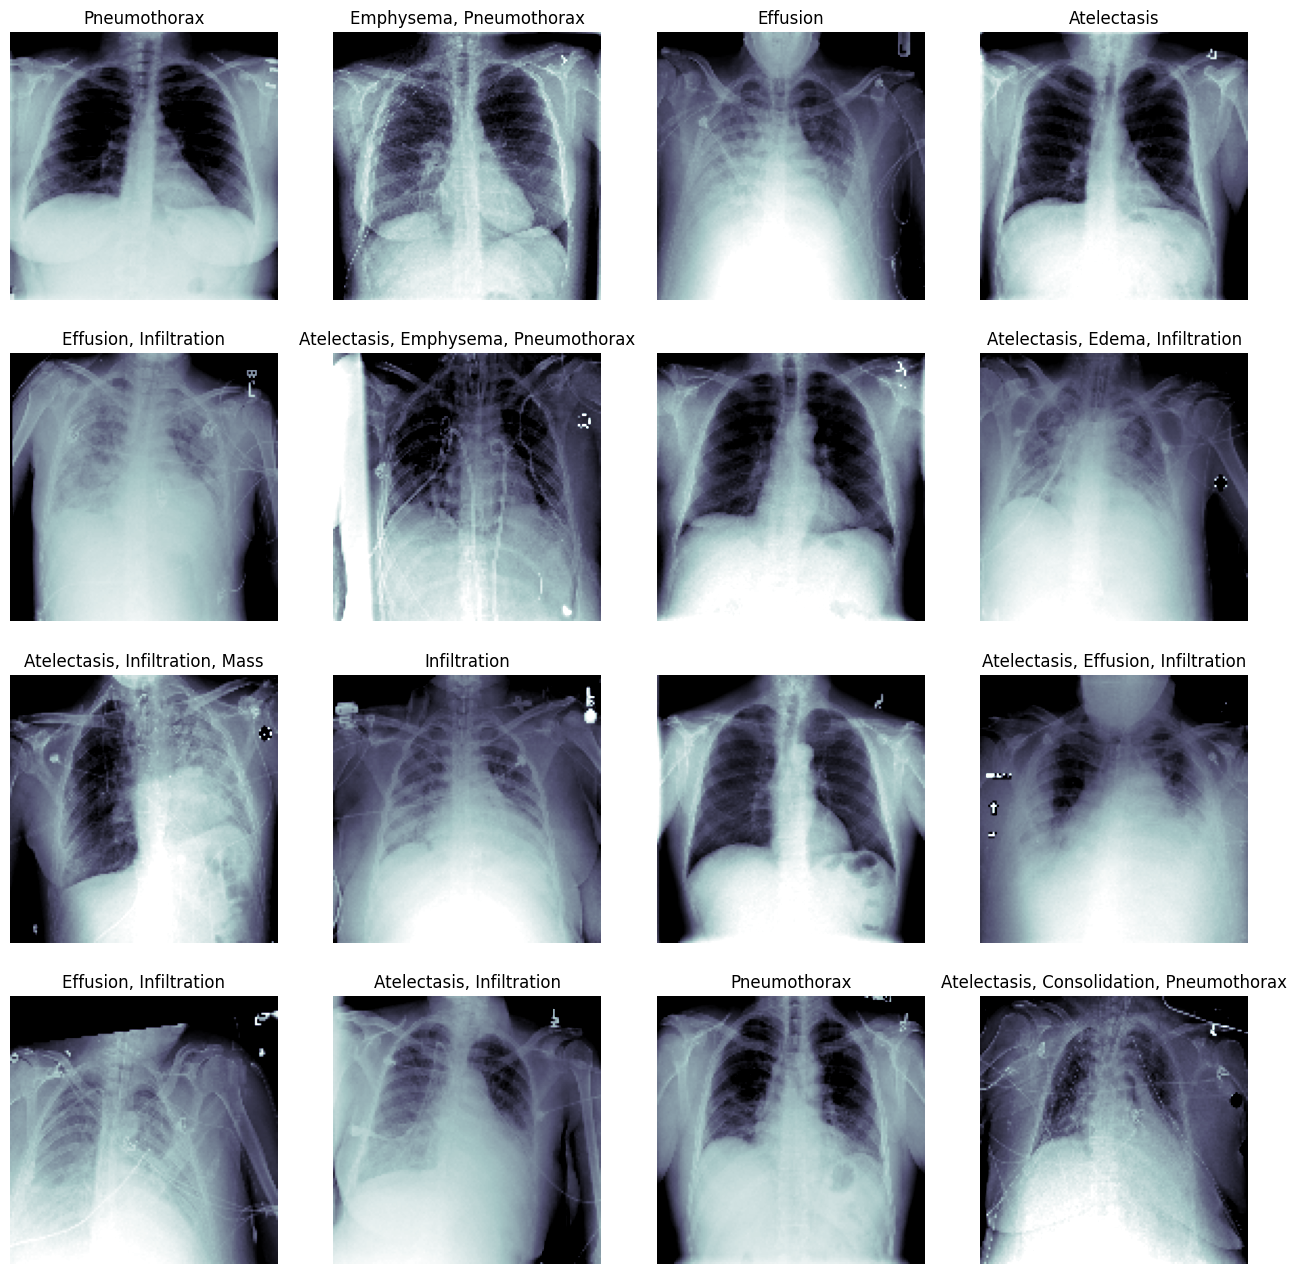

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

In [ ]:
# create the validating data generator for the validating images.
valid_gen = flow_from_dataframe(core_idg,
                                train_df,
                                path_col = 'path',
                                y_col = 'disease_vec',
                                batch_size = 256,
                                target_size = IMG_SIZE,
                                color_mode = 'grayscale'
                                )

# valid_gen = flow_from_dataframe(core_idg,
#                                 valid_df,
#                                 path_col = 'path',
#                                 y_col = 'disease_vec',
#                                 target_size = IMG_SIZE,
#                                 color_mode = 'grayscale',
#                                 batch_size = 256) # we can use much larger batches for evaluation

# used a fixed dataset for evaluating the algorithm
# test_X, test_Y = next(valid_gen)
test_X, test_Y = next(flow_from_dataframe(core_idg,
                                          valid_df,
                                          path_col = 'path',
                                          y_col = 'disease_vec',
                                          batch_size = 1024,
                                          target_size = IMG_SIZE,
                                          color_mode = 'grayscale')) # one big batch


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:],
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional)      │ (None, 4, 4, 1024)          │       3,228,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 13)                  │           6,669 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,759,757 (14.34 MB)

 Trainable params: 3,737,869 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

# Change the file extension to .weights.h5
weight_path = weight_path.replace(".hdf5", ".weights.h5")  # Fix: Change extension to .weights.h5

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
multi_disease_model.fit(train_gen,  # Use fit instead of fit_generator
                         steps_per_epoch=100,
                         validation_data=(test_X, test_Y),
                         epochs=1,
                         callbacks=callbacks_list)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - binary_accuracy: 0.8091 - loss: 0.5263 - mae: 0.2320
Epoch 1: val_loss improved from inf to 0.42318, saving model to xray_class_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 209ms/step - binary_accuracy: 0.8092 - loss: 0.5259 - mae: 0.2319 - val_binary_accuracy: 0.8175 - val_loss: 0.4232 - val_mae: 0.3010


In [ ]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 28.00%
Cardiomegaly: 8.00%
Consolidation: 11.20%
Edema: 4.80%
Effusion: 36.40%
Emphysema: 5.20%
Fibrosis: 4.00%
Infiltration: 46.00%
Mass: 12.00%
Nodule: 14.80%
Pleural_Thickening: 6.00%
Pneumonia: 4.00%
Pneumothorax: 12.80%


In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step


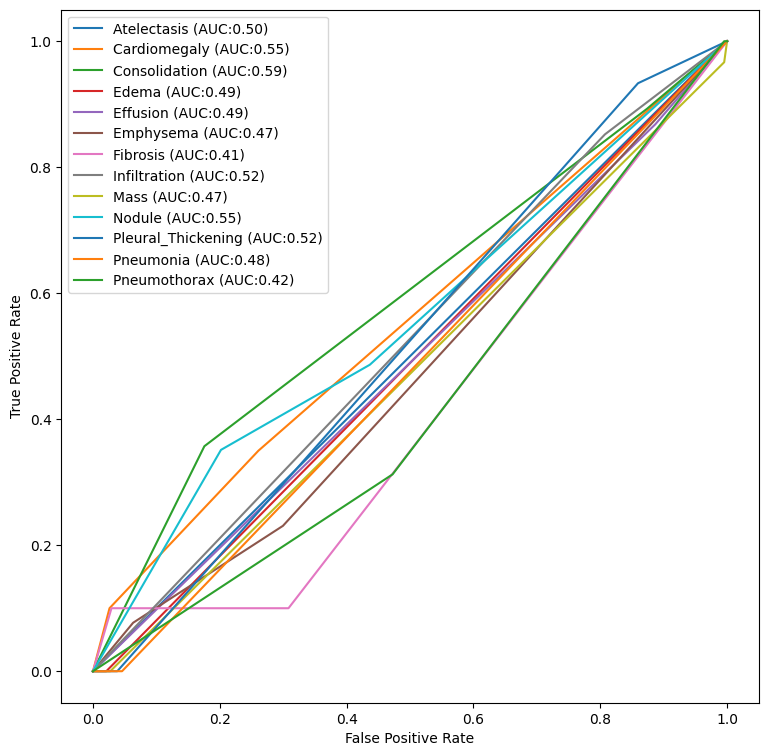

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

**why only 3 epochs were run when 1000 data points are sampled?**

The reason for this is the EarlyStopping callback that is included in the training process.
  

*   early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
*   callbacks_list = [checkpoint, early]
                     

In [ ]:
#  In modern Keras, the fit method is used instead and it can accept data generators directly.
# multi_disease_model.fit_generator(train_gen,
#                                   steps_per_epoch = 100,
#                                   validation_data =  (test_X, test_Y),
#                                   epochs = 5,
#                                   callbacks = callbacks_list)

multi_disease_model.fit(train_gen,  # Use fit instead of fit_generator
                        steps_per_epoch = 100,
                        validation_data =  (test_X, test_Y),
                        epochs = 5,
                        callbacks = callbacks_list)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.8437 - loss: 0.4093 - mae: 0.2143
Epoch 1: val_loss did not improve from 0.42318
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - binary_accuracy: 0.8437 - loss: 0.4091 - mae: 0.2142 - val_binary_accuracy: 0.8514 - val_loss: 0.4416 - val_mae: 0.1908
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - binary_accuracy: 0.8731 - loss: 0.3311 - mae: 0.1866
Epoch 2: val_loss did not improve from 0.42318
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - binary_accuracy: 0.8731 - loss: 0.3309 - mae: 0.1865 - val_binary_accuracy: 0.8514 - val_loss: 0.6037 - val_mae: 0.1590
Epoch 3/5
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.8951 - loss: 0.2726 - mae: 0.1520
Epoch 3: val_loss did not improve from 0.42318
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - binary_accuracy: 0.8952 - loss: 0.2722 - mae: 0.1518 - val_binary_accuracy: 0.8514 - val_loss: 0.7810 - val_mae: 0.1535


In [ ]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


**t_count** represents the true percentage (or prevalence) of a specific disease in the test set.

**p_count ** represents the predicted percentage (or prevalence) of a specific disease in the test set, as estimated by the model.

p_count is used to print the model's estimated prevalence of each disease in the test set, alongside the actual prevalence (t_count).

Imagine you have 100 patients in your test set, and 20 of them have Pneumonia. In this case, t_count for Pneumonia would be 20% (or 0.2), representing the true prevalence of Pneumonia in your test set.

**Why t_count is important:**

1.   Evaluating Model Performance: Comparing t_count and p_count helps you assess how well your model is predicting the prevalence of each disease.
2.   Understanding Disease Distribution: It provides insights into the distribution of diseases in your test set, which can be valuable for understanding the data and potential biases.
3.   Calibration: Comparing t_count and p_count can reveal if your model is well-calibrated, meaning its predicted probabilities are accurate reflections of the true probabilities.







In [ ]:
# look at how often the algorithm predicts certain diagnoses
for c_label, p_count, t_count in zip(all_labels,
                                     100*np.mean(pred_Y,0),
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 28.00%, PDx: 56.69%
Cardiomegaly: Dx: 8.00%, PDx: 7.48%
Consolidation: Dx: 11.20%, PDx: 28.73%
Edema: Dx: 4.80%, PDx: 16.34%
Effusion: Dx: 36.40%, PDx: 32.83%
Emphysema: Dx: 5.20%, PDx: 21.46%
Fibrosis: Dx: 4.00%, PDx: 8.61%
Infiltration: Dx: 46.00%, PDx: 46.55%
Mass: Dx: 12.00%, PDx: 21.48%
Nodule: Dx: 14.80%, PDx: 29.87%
Pleural_Thickening: Dx: 6.00%, PDx: 28.02%
Pneumonia: Dx: 4.00%, PDx: 3.87%
Pneumothorax: Dx: 12.80%, PDx: 32.86%


fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])

**What is a Threshold?**

In binary classification (where you're predicting whether something is or isn't a certain thing, like whether an email is spam or not spam), a threshold is a cut-off value used to convert the model's predicted probabilities into a class prediction (e.g., "spam" or "not spam").

**How it Works**



1.   Model Prediction: Your model outputs a probability (between 0 and 1) representing the likelihood of the positive class (e.g., the likelihood that an email is spam).
2.   Threshold Comparison: This predicted probability is compared to the threshold value.
3.   Class Prediction:
If the predicted probability is greater than or equal to the threshold, the model predicts the positive class (e.g., "spam").
If the predicted probability is less than the threshold, the model predicts the negative class (e.g., "not spam").




**Default Threshold**

A typical default choice for the threshold is 0.5. This means if the model predicts a probability of 0.5 or higher, it classifies the input as belonging to the positive class.

**Why Thresholds Matter**

*   Balancing Precision and Recall: Adjusting the threshold allows you to control the trade-off between precision (avoiding false positives) and recall (avoiding false negatives). A higher threshold leads to higher precision but lower recall, and vice versa.
*   Cost of Errors: Depending on the application, different types of errors might have different costs. For example, in medical diagnosis, a false negative (missing a disease) could be more costly than a false positive (incorrectly diagnosing a disease). Adjusting the threshold helps you optimize for the specific cost structure.

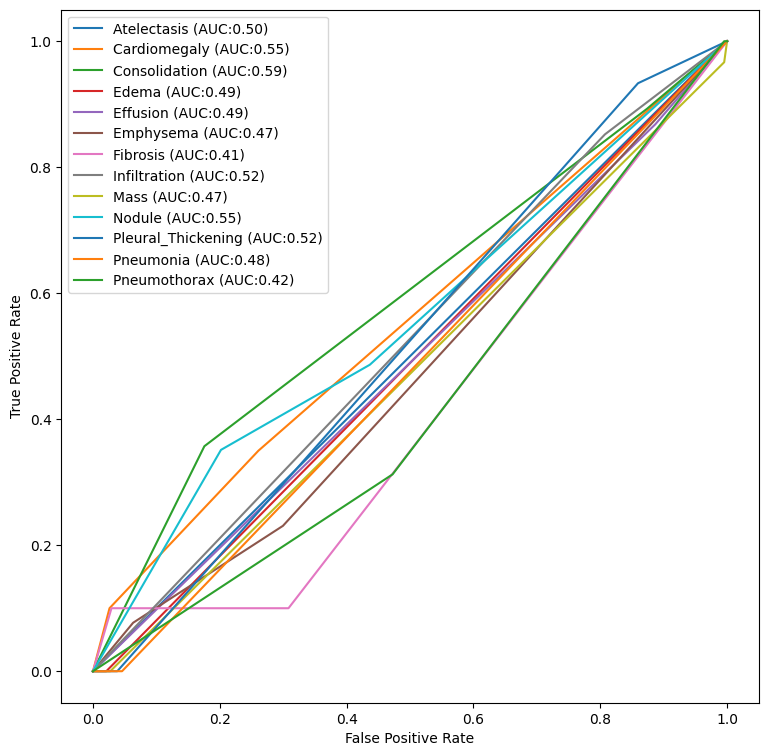

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

The code below visualizes the model's predictions on the images of the sickest patients, showing the actual diagnoses (Dx) and the predicted diagnoses (PDx).

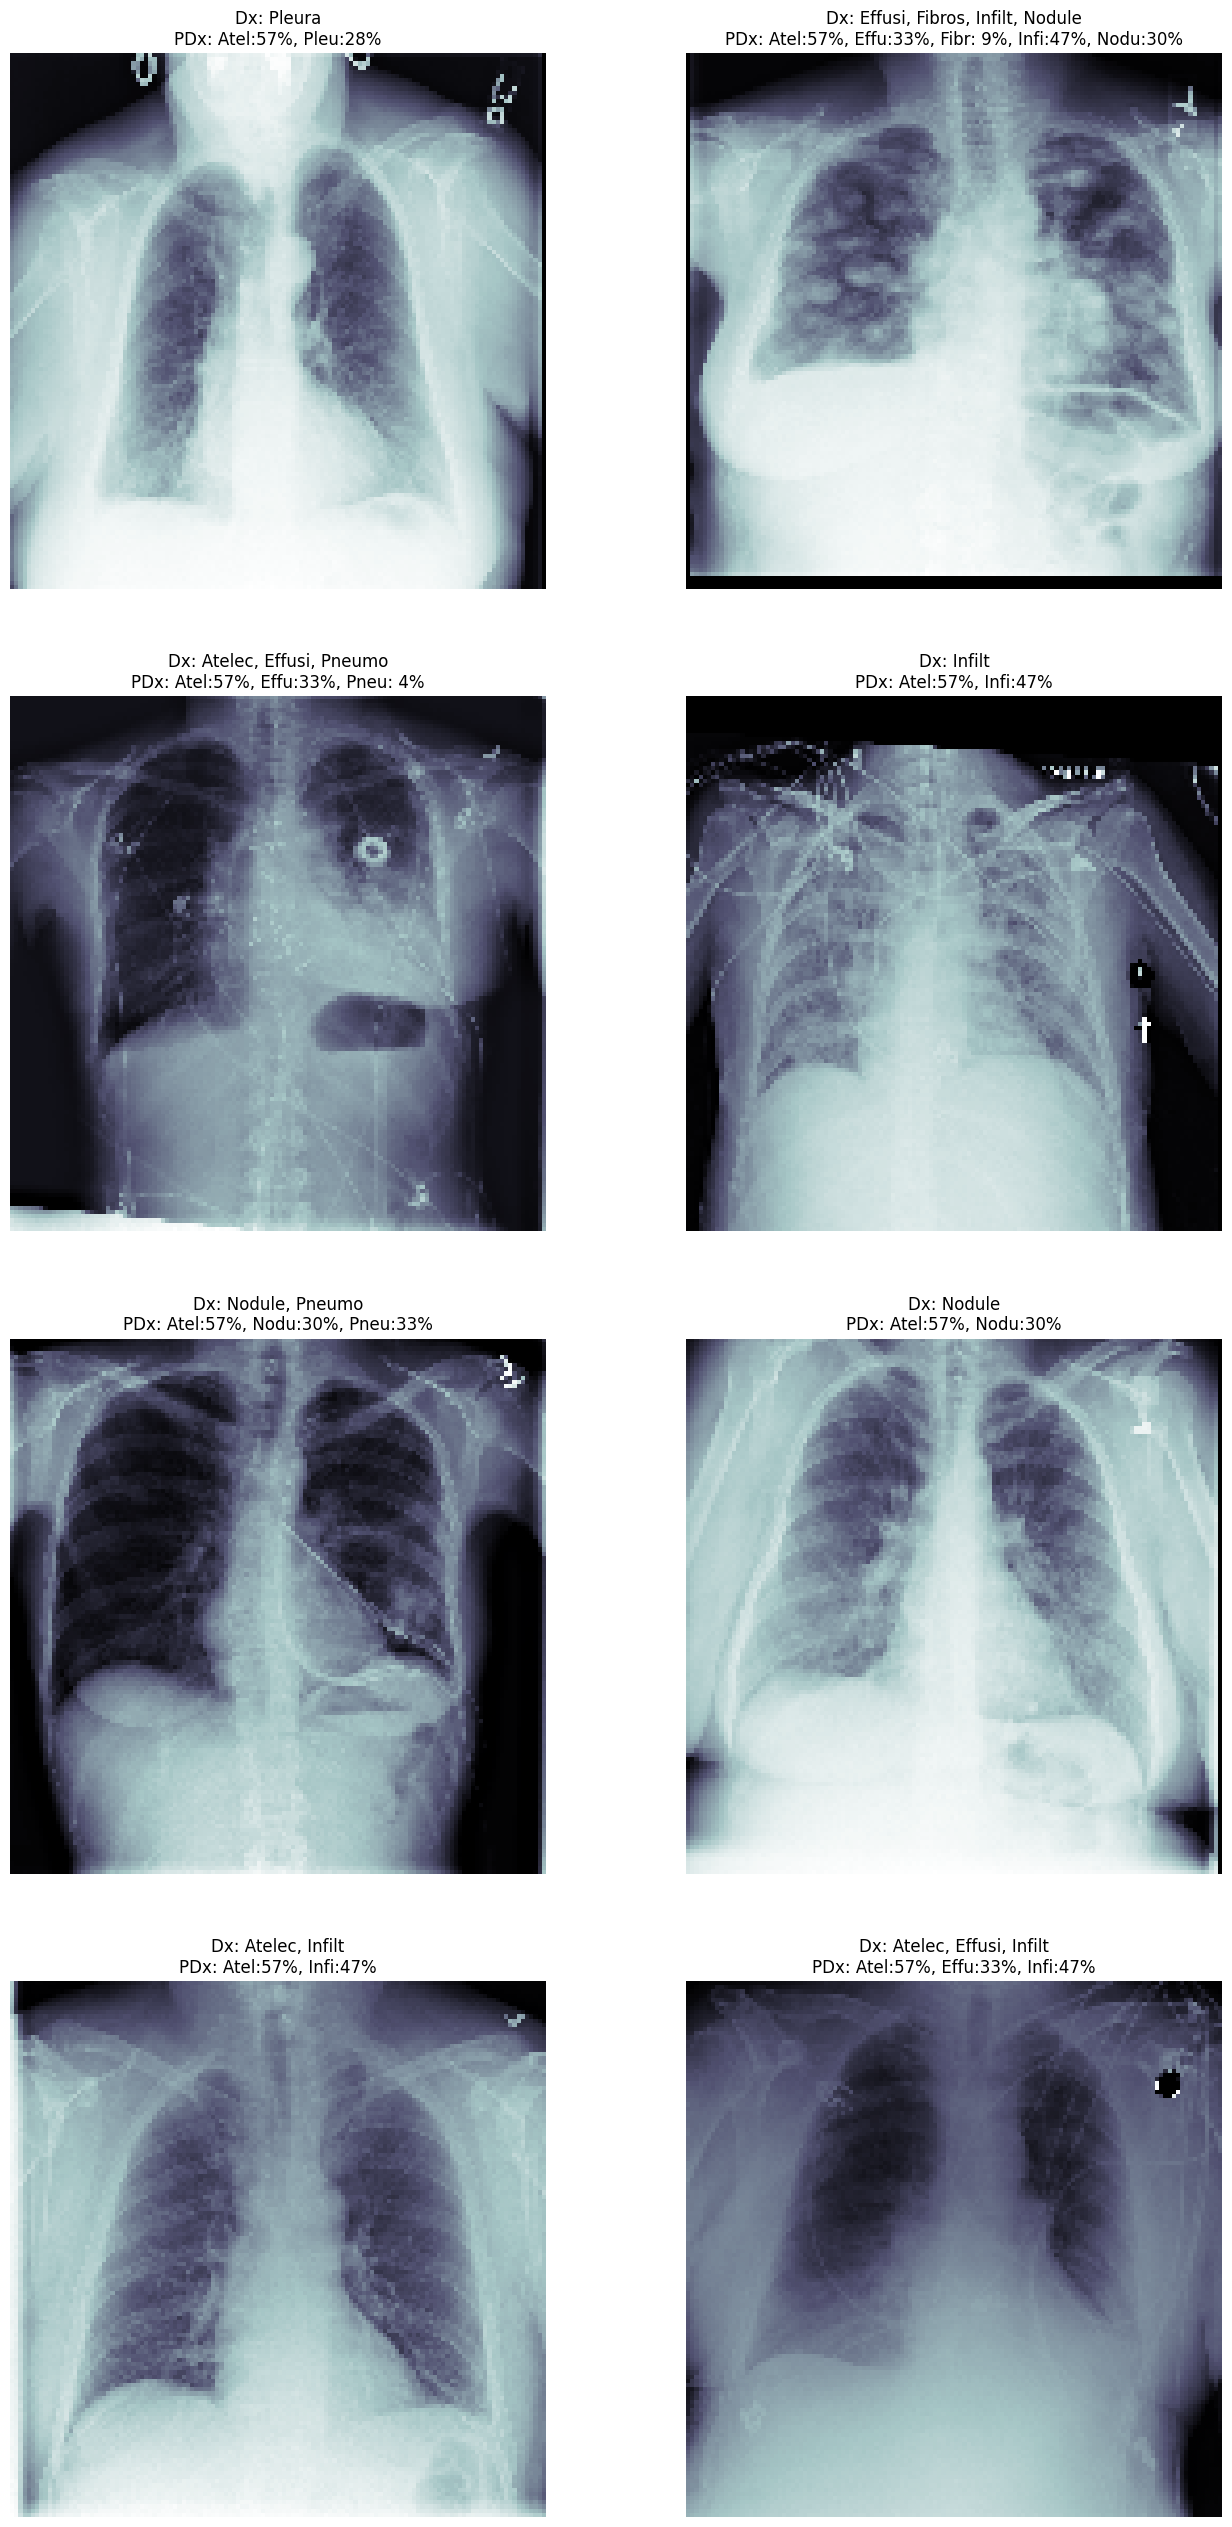

In [ ]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))  # plot 4 rows, each row has 2 images.
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels,
                                                                  test_Y[idx])
                             if n_score>0.5]
    # p_score value represents the predicted probability that a patient has a particular disease.
    # Imagine the model is looking at a chest X-ray. If the p_score for "Pneumonia" is 0.8 (or 80%),
    # it means the model believes there's an 80% chance that the patient in the X-ray has Pneumonia.
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels,
                                                                  test_Y[idx], pred_Y[idx])
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')